# NGFC Modelling with IDEAS - pse
This is a modelling example of a NGFC system using idaes-pse framework.

In [1]:
from pyomo.environ import ConcreteModel, Constraint, Objective, SolverFactory, TransformationFactory, Constraint, Var
from pyomo.network import Arc

In [1]:
from idaes.core import FlowsheetBlock
from idaes.unit_models import Mixer, HeatExchanger, Separator, GibbsReactor, Heater
# Methane combustion ideal package got CH4, H2O, CO, CO2, N2, NH3, O2
import idaes.property_models.activity_coeff_models.methane_combustion_ideal as thermo_props
#import idaes.property_models.activity_coeff_models.methane_combustion_ideal as reaction_props

ModuleNotFoundError: No module named 'idaes.unit_models'

In [3]:
import matplotlib.pyplot as plt

In [4]:
from idaes.unit_models.separator import SplittingType
from idaes.unit_models.heat_exchanger import delta_temperature_amtd_callback
from idaes.core.util.model_statistics import degrees_of_freedom as dof

### Building Base Flowsheet.

In [5]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
m.fs.thermo_params = thermo_props.MethaneParameterBlock()

In [6]:
# Fuel ultilization (Uf): mole reductant consumed in FC per mole of reductant total
Uf = 0.8
# Air ultilization (Ua): mole of air consumed in FC per mole of air feed
Ua = 0.2
# Methane to steam ratio (MS): mole methane per mole water
MS = 2
# Electrical conversion efficiency (EE): 
EE = 0.9
#Methane LHV: (https://www.engineeringtoolbox.com/fuels-higher-calorific-values-d_169.html)
LHV = 50000*16.04 # (J/g * g/mol = J/mol) 
# Heat of water vaporization @ 25 C: (https://www.engineeringtoolbox.com/water-properties-d_1573.html)
enthalpy_vap = 43988 # (J/mol)
# Feed:
# Reaction: 
# Reforming: CH4 + H2O -> CO + 3H2
# Water gas shift: CO + H2O -> CO2 + H2
# Methane combustion: CH4 + 2O2 -> CO2 + 2H2O
# Hydrogen combustion: H2 + 1/2O2 -> H2O
# Carbon monoxide combustion: CO + 1/2O2 -> CO2

n_CH4f = 10
print("mole of methane feed: "+str(n_CH4f)+" mole/s")
n_H2Of = n_CH4f*MS
print("mole of steam feed: "+str(n_H2Of)+" mole/s")
n_O2f = n_CH4f*Uf*2/Ua
n_N2f = n_O2f*0.79/0.21
print("mole of air feed: "+str(n_N2f+n_O2f)+" mole/s")

n_H2ex = 2
n_COex = n_CH4f*(1-Uf)*4-n_H2ex
n_CO2ex = n_CH4f-n_COex
n_H2Oex = n_H2Of+2*n_CH4f-n_H2ex
y_H2ex = n_H2ex/(n_H2ex + n_COex + n_CO2ex + n_H2Oex)
y_COex = n_COex/(n_H2ex + n_COex + n_CO2ex + n_H2Oex)
y_CO2ex = n_CO2ex/(n_H2ex + n_COex + n_CO2ex + n_H2Oex)
y_H2Oex = n_H2Oex/(n_H2ex + n_COex + n_CO2ex + n_H2Oex)

print("Anode exhaust: ")
print("y_H2ex: "+str(y_H2ex))
print("y_COex: "+str(y_COex))
print("y_CO2ex: "+str(y_CO2ex))
print("y_H2Oex: "+str(y_H2Oex))
print("Total mole/s: "+str(n_H2ex + n_COex + n_CO2ex + n_H2Oex))

n_N2ex = n_N2f
n_O2ex = n_O2f - n_CH4f*Uf*2
y_O2ex = n_O2ex/(n_O2ex+n_N2ex)
y_N2ex = n_N2ex/(n_O2ex+n_N2ex)
print("Cathode exhaust: ")
print("y_O2ex: "+str(y_O2ex))
print("y_N2ex: "+str(y_N2ex))
print("Total mole/s: "+str(n_O2ex+n_N2ex))

mole of methane feed: 10 mole/s
mole of steam feed: 20 mole/s
mole of air feed: 380.95238095238096 mole/s
Anode exhaust: 
y_H2ex: 0.04
y_COex: 0.11999999999999997
y_CO2ex: 0.08000000000000003
y_H2Oex: 0.76
Total mole/s: 50.0
Cathode exhaust: 
y_O2ex: 0.1753653444676409
y_N2ex: 0.824634655532359
Total mole/s: 364.95238095238096


In [7]:
# Temperature input
# Need to know: 
# _temperature of air coming in to fuel cell (FC) (T_FC_air_in)
# _temperature of fuel coming into (FC)/temperature of reformer (T_FC_fuel_in)
# _temperature of exhaust coming out of FC (T_FC_ex_out)
T_FC_air_in = 700 + 273.15
T_FC_fuel_in = 500 + 273.15
T_FC_ex_out = 800 + 273.15

### Blue coded solid material streams can be solved from given specifications

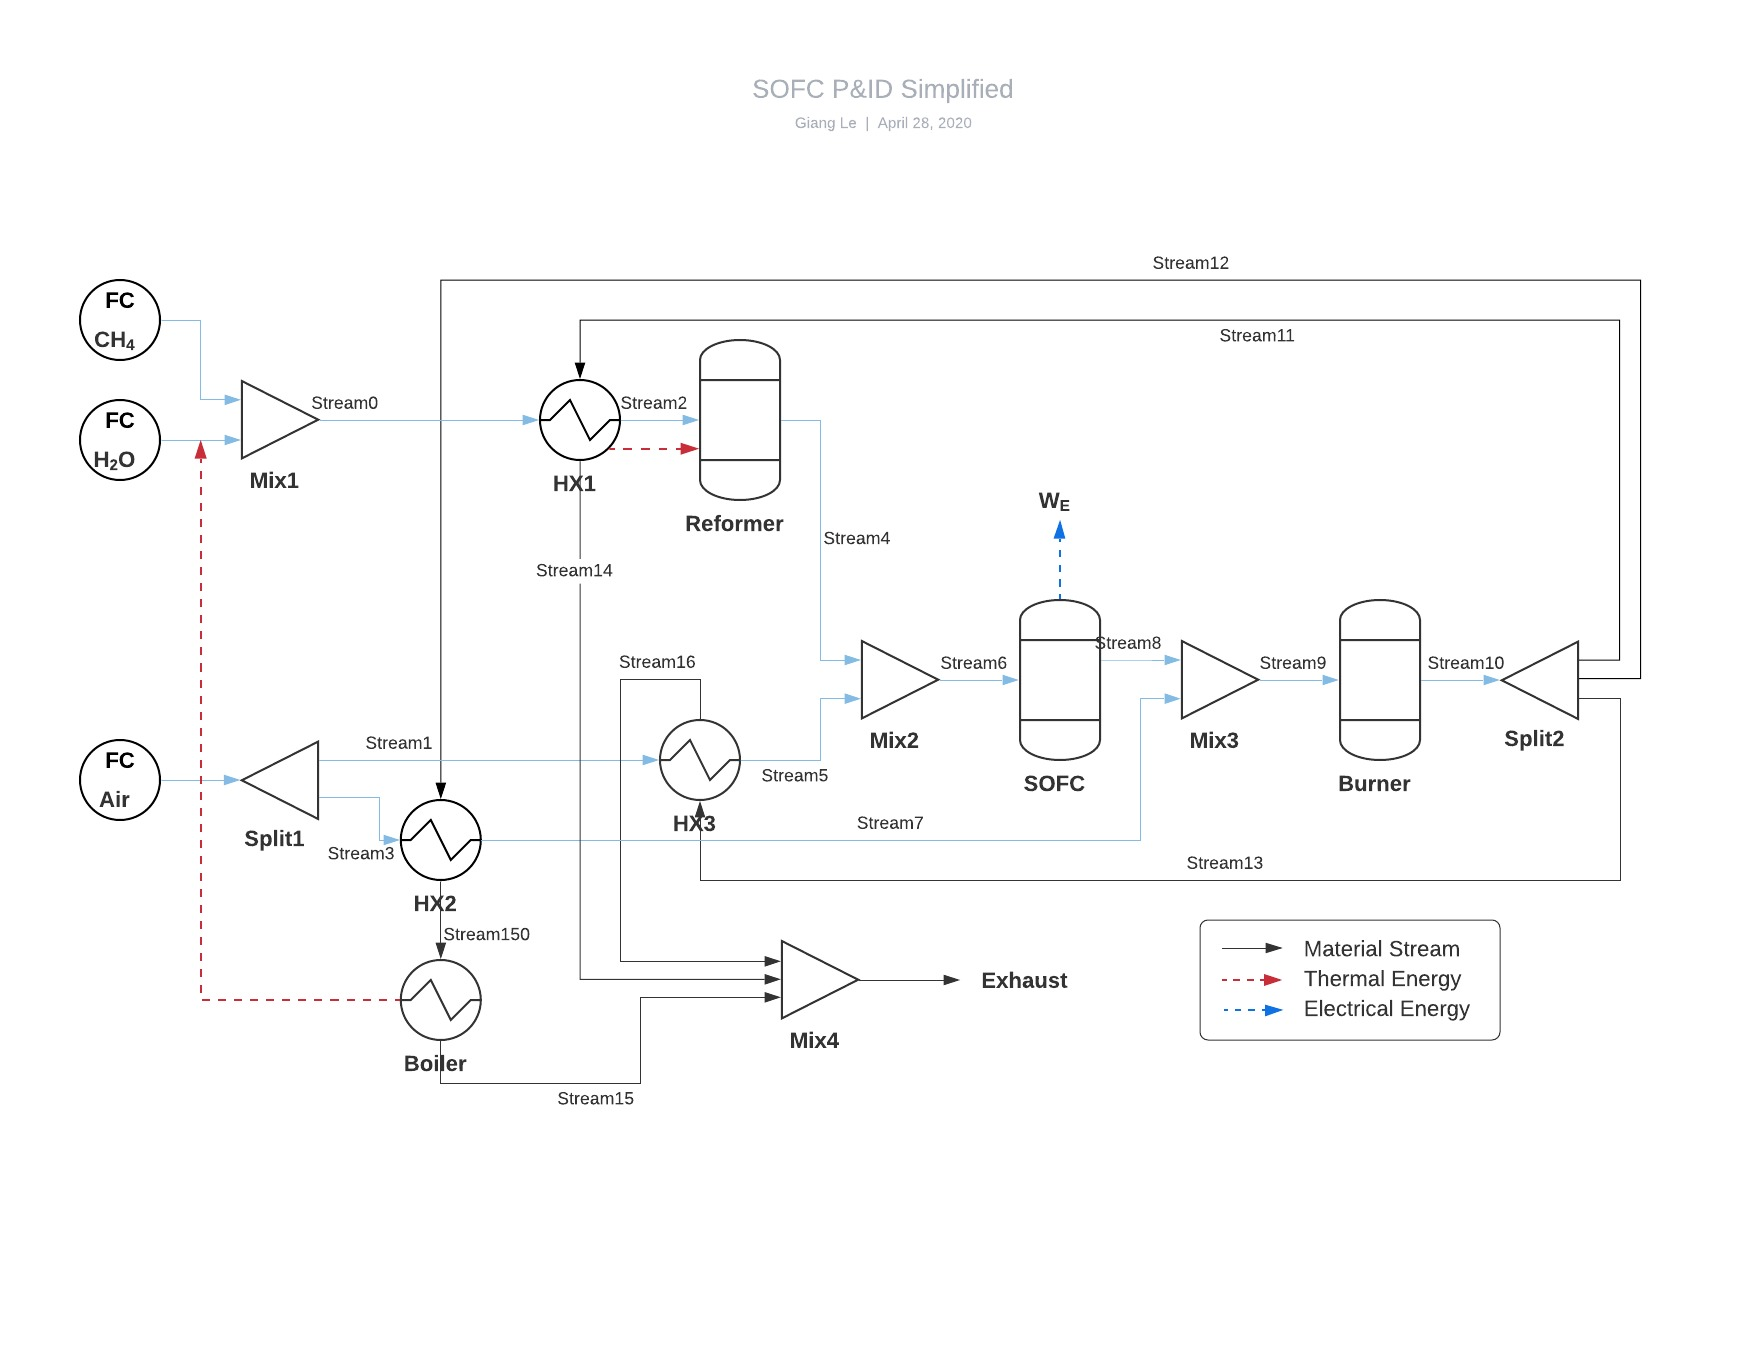

In [8]:
from IPython.display import Image
Image(filename='../../assets/images/SOFC-P&ID-Simplified.jpeg') 

### Declare all Units:

In [9]:
# Cold/tube side of the heat exchanger HX1
m.fs.HX1c = Heater(default={"property_package": m.fs.thermo_params})

In [10]:
# Cold/tube side of the heat exchanger HX2
m.fs.HX2c = Heater(default={"property_package": m.fs.thermo_params})

In [11]:
# Cold/tube side of the heat exchanger HX3
m.fs.HX3c = Heater(default={"property_package": m.fs.thermo_params})

In [12]:
m.fs.Mix1 = Mixer(default={"dynamic": False,
                           "property_package": m.fs.thermo_params})

In [13]:
m.fs.Mix2 = Mixer(default={"dynamic": False,
                           "property_package": m.fs.thermo_params})

In [14]:
m.fs.Mix3 = Mixer(default={"dynamic": False,
                           "property_package": m.fs.thermo_params})

In [15]:
# Split1 is splits the air stream into a O2 flow that crosses the anode/cathode/electrolyte layers
m.fs.Split1 = Separator(default={"dynamic": False,
                                 "split_basis": SplittingType.componentFlow,
                                 "property_package": m.fs.thermo_params})

In [16]:
m.fs.Reformer = GibbsReactor(default={"dynamic": False,
                                      "property_package": m.fs.thermo_params,
                                      "has_pressure_change": False,
                                      "has_heat_transfer": True})

In [17]:
m.fs.SOFC = GibbsReactor(default={"dynamic": False,
                                  "property_package": m.fs.thermo_params,
                                  "has_pressure_change": False,
                                  "has_heat_transfer": True})

In [18]:
m.fs.Burner = GibbsReactor(default={"dynamic": False,
                                    "property_package": m.fs.thermo_params,
                                    "has_pressure_change": False,
                                    "has_heat_transfer": True})

### Declare all Streams:

In [19]:
m.fs.stream0 = Arc(source=m.fs.Mix1.outlet,
                   destination=m.fs.HX1c.inlet)

In [20]:
m.fs.stream1 = Arc(source=m.fs.Split1.outlet_1,
                   destination=m.fs.HX3c.inlet)

In [21]:
m.fs.stream2 = Arc(source=m.fs.HX1c.outlet,
                   destination=m.fs.Reformer.inlet)

In [22]:
m.fs.stream3 = Arc(source=m.fs.Split1.outlet_2,
                   destination=m.fs.HX2c.inlet)

In [23]:
m.fs.stream4 = Arc(source=m.fs.Reformer.outlet,
                   destination=m.fs.Mix2.inlet_1)

In [24]:
m.fs.stream5 = Arc(source=m.fs.HX3c.outlet,
                   destination=m.fs.Mix2.inlet_2)

In [25]:
m.fs.stream6 = Arc(source=m.fs.Mix2.outlet,
                   destination=m.fs.SOFC.inlet)

In [26]:
m.fs.stream7 = Arc(source=m.fs.HX2c.outlet,
                   destination=m.fs.Mix3.inlet_2)

In [27]:
m.fs.stream8 = Arc(source=m.fs.SOFC.outlet,
                   destination=m.fs.Mix3.inlet_1)

In [28]:
m.fs.stream9 = Arc(source=m.fs.Mix3.outlet,
                   destination=m.fs.Burner.inlet)

In [29]:
TransformationFactory("network.expand_arcs").apply_to(m)

### Define known Material Streams:

In [30]:
# Fix methane flow to Mix1:
m.fs.Mix1.inlet_1.flow_mol.fix(n_CH4f)
m.fs.Mix1.inlet_1.mole_frac_comp[0.0,:].fix(0.0)
m.fs.Mix1.inlet_1.mole_frac_comp[0.0,"CH4"].fix(1.0)
m.fs.Mix1.inlet_1.temperature.fix(25+273.15)
m.fs.Mix1.inlet_1.pressure.fix(101325)

In [31]:
# Fix water flow to Mix1:
m.fs.Mix1.inlet_2.flow_mol.fix(n_H2Of)
m.fs.Mix1.inlet_2.mole_frac_comp[0.0,:].fix(0.0)
m.fs.Mix1.inlet_2.mole_frac_comp[0.0,"H2O"].fix(1.0)
m.fs.Mix1.inlet_2.temperature.fix(25+273.15)
m.fs.Mix1.inlet_2.pressure.fix(101325)

In [32]:
# Fix air flow to Split1:
m.fs.Split1.inlet.flow_mol.fix(n_N2f+n_O2f)
m.fs.Split1.inlet.mole_frac_comp[0.0,:].fix(0.0)
m.fs.Split1.inlet.mole_frac_comp[0.0,"O2"].fix(0.21)
m.fs.Split1.inlet.mole_frac_comp[0.0,"N2"].fix(0.79)
m.fs.Split1.inlet.temperature.fix(25+273.15)
m.fs.Split1.inlet.pressure.fix(101325)

In [33]:
# Fix O2 flow in Split1 outlet_1:
m.fs.Split1.outlet_1.flow_mol.fix(n_CH4f*Uf*2)
m.fs.Split1.outlet_1.mole_frac_comp[0.0,"CH4"].fix(0.0)
m.fs.Split1.outlet_1.mole_frac_comp[0.0,"CO"].fix(0.0)
m.fs.Split1.outlet_1.mole_frac_comp[0.0,"CO2"].fix(0.0)
m.fs.Split1.outlet_1.mole_frac_comp[0.0,"H2"].fix(0.0)
m.fs.Split1.outlet_1.mole_frac_comp[0.0,"H2O"].fix(0.0)
m.fs.Split1.outlet_1.mole_frac_comp[0.0,"N2"].fix(0.0)
m.fs.Split1.outlet_1.mole_frac_comp[0.0,"O2"].fix(1.0)

### Constraints:  Adiabatic Burner

In [34]:
m.fs.Burner.heat_duty.fix(0.0)

In [35]:
m.fs.Reformer.heat_duty.fix(0.0)

### Constraints: Reformer temperature

In [36]:
m.fs.Reformer.outlet.temperature.fix(T_FC_fuel_in)

### Constraints: SOFC exit temperature

In [37]:
m.fs.SOFC.outlet.temperature.fix(T_FC_ex_out)

### Constraints: Heat Exchanger tube outlet temperature

In [38]:
m.fs.HX2c.outlet.temperature.fix(T_FC_ex_out)

In [39]:
m.fs.HX3c.outlet.temperature.fix(T_FC_air_in)

In [40]:
dof(m)

0

### Initialize Blocks

In [41]:
m.fs.Mix1.initialize()
m.fs.Mix2.initialize()
m.fs.Mix3.initialize()
m.fs.HX1c.initialize()
m.fs.HX2c.initialize()
m.fs.HX3c.initialize()
m.fs.Split1.initialize()

--- Logging error ---
Traceback (most recent call last):
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/adlerlabadmin/a

--- Logging error ---
Traceback (most recent call last):
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/adlerlabadmin/a

2020-04-28 13:14:28 - INFO - idaes.property_models.activity_coeff_models.activity_coeff_prop_pack - fs.Mix1.mixed_state State Released.
2020-04-28 13:14:28 - INFO - idaes.property_models.activity_coeff_models.activity_coeff_prop_pack - fs.Mix1.inlet_1_state State Released.
2020-04-28 13:14:28 - INFO - idaes.property_models.activity_coeff_models.activity_coeff_prop_pack - fs.Mix1.inlet_2_state State Released.


--- Logging error ---
Traceback (most recent call last):
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/adlerlabadmin/a

--- Logging error ---
Traceback (most recent call last):
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/adlerlabadmin/a

2020-04-28 13:14:28 - INFO - idaes.property_models.activity_coeff_models.activity_coeff_prop_pack - fs.Mix2.mixed_state State Released.
2020-04-28 13:14:28 - INFO - idaes.property_models.activity_coeff_models.activity_coeff_prop_pack - fs.Mix2.inlet_1_state State Released.
2020-04-28 13:14:28 - INFO - idaes.property_models.activity_coeff_models.activity_coeff_prop_pack - fs.Mix2.inlet_2_state State Released.


--- Logging error ---
Traceback (most recent call last):
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/adlerlabadmin/a

--- Logging error ---
Traceback (most recent call last):
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/adlerlabadmin/a

2020-04-28 13:14:29 - INFO - idaes.property_models.activity_coeff_models.activity_coeff_prop_pack - fs.Mix3.mixed_state State Released.
2020-04-28 13:14:29 - INFO - idaes.property_models.activity_coeff_models.activity_coeff_prop_pack - fs.Mix3.inlet_1_state State Released.
2020-04-28 13:14:29 - INFO - idaes.property_models.activity_coeff_models.activity_coeff_prop_pack - fs.Mix3.inlet_2_state State Released.


--- Logging error ---
Traceback (most recent call last):
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/adlerlabadmin/a

2020-04-28 13:14:30 - INFO - idaes.property_models.activity_coeff_models.activity_coeff_prop_pack - fs.HX1c.control_volume.properties_out State Released.
2020-04-28 13:14:30 - INFO - idaes.property_models.activity_coeff_models.activity_coeff_prop_pack - fs.HX1c.control_volume.properties_in State Released.


--- Logging error ---
Traceback (most recent call last):
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/adlerlabadmin/a

2020-04-28 13:14:30 - INFO - idaes.property_models.activity_coeff_models.activity_coeff_prop_pack - fs.HX2c.control_volume.properties_out State Released.
2020-04-28 13:14:30 - INFO - idaes.property_models.activity_coeff_models.activity_coeff_prop_pack - fs.HX2c.control_volume.properties_in State Released.


--- Logging error ---
Traceback (most recent call last):
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/adlerlabadmin/a

2020-04-28 13:14:31 - INFO - idaes.property_models.activity_coeff_models.activity_coeff_prop_pack - fs.HX3c.control_volume.properties_out State Released.
2020-04-28 13:14:31 - INFO - idaes.property_models.activity_coeff_models.activity_coeff_prop_pack - fs.HX3c.control_volume.properties_in State Released.


--- Logging error ---
Traceback (most recent call last):
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/adlerlabadmin/a

2020-04-28 13:14:31 - INFO - idaes.property_models.activity_coeff_models.activity_coeff_prop_pack - fs.Split1.outlet_1_state State Released.


KeyError: 'fs.Split1 state variable and split fraction indexing sets do not match. The in-built  initialization routine for Separators relies on the split fraction and state variable indexing sets matching to calculate initial guesses for extensive variables. In other cases users will need to provide their own initial guesses'

### Solve:

In [42]:
solver = SolverFactory('ipopt')

In [43]:
results = solver.solve(m, tee=True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2425
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      654

Total number of variables............................:      710
                     variables with only lower bounds:       58
                variables with lower and upper bounds:      353
                     variables with only upper bounds:        0
Total

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
  61  0.0000000e+00 3.14e+05 1.25e+17  -1.0 5.34e+07    -  6.61e-01 1.93e-02h  2
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
  62  0.0000000e+00 3.07e+05 1.20e+17  -1.0 5.34e+07    -  5.64e-01 2.11e-02h  2
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
  63  0.0000000e+00 3.08e+05 9.80e+16  -1.0 5.30e+07    -  4.93e-01 2.47e-02h  2
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
  64  0.0000000e+00 3.13e+05 9.52e+16  -1.0 5.20e+07    -  4.40e-01 1.74e-02h  3
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
  65  0.0000000e+00 3.21e+05 9.02e+16  -1.0 5.09e+07    -  9.90e-01 2.32e-02h  3
Error in an AMPL evaluation. Run with "hal

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 125  0.0000000e+00 2.65e+00 1.62e+12  -1.0 1.43e+04    -  1.00e+00 1.25e-01h  4
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 126  0.0000000e+00 2.58e+00 1.42e+12  -1.0 1.45e+04    -  1.00e+00 1.25e-01h  3
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 127  0.0000000e+00 2.53e+00 1.24e+12  -1.0 1.47e+04    -  1.00e+00 1.25e-01h  4
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 128  0.0000000e+00 2.48e+00 1.08e+12  -1.0 1.49e+04    -  1.00e+00 1.25e-01h  4
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 129  0.0000000e+00 2.44e+00 9.49e+11  -1.0 1.52e+04    -  1.00e+00 1.25e-01h  4
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  0.0000000e+00 2.40e+00 8.30e+11  -

 185  0.0000000e+00 1.10e+00 2.08e+10  -1.0 1.82e+04    -  1.00e+00 6.25e-02h  5
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 186  0.0000000e+00 1.09e+00 1.95e+10  -1.0 1.83e+04    -  1.00e+00 6.25e-02h  4
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 187  0.0000000e+00 1.09e+00 1.83e+10  -1.0 1.83e+04    -  1.00e+00 6.25e-02h  5
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 188  0.0000000e+00 1.09e+00 1.71e+10  -1.0 1.83e+04    -  1.00e+00 6.25e-02h  5
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 189  0.0000000e+00 1.09e+00 1.61e+10  -1.0 1.83e+04    -  1.00e+00 6.25e-02h  5
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  0.0000000e+00 1.09e+00 1.50e+10  -1.0 1.83e+04    -  1.00e+00 6.25e-02h  5
Error in an AMPL evaluation. Run with 

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 244  0.0000000e+00 6.37e-01 2.30e+09  -1.0 1.82e+04    -  1.00e+00 3.12e-02h  6
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 245  0.0000000e+00 6.33e-01 2.23e+09  -1.0 1.82e+04    -  1.00e+00 3.12e-02h  6
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 246  0.0000000e+00 6.30e-01 2.16e+09  -1.0 1.82e+04    -  1.00e+00 3.12e-02h  5
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 247  0.0000000e+00 6.26e-01 2.09e+09  -1.0 1.82e+04    -  1.00e+00 3.12e-02h  6
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 248  0.0000000e+00 6.23e-01 2.03e+09  -1.0 1.82e+04    -  1.00e+00 3.12e-02h  6
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 249  0.0000000e+00 6.20e-01 1.96e+09  -1.0 1.82e+04    -  1.00e+00 3.12e-02h  6
Error in an AMPL evaluation. Run with "h

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 302  0.0000000e+00 5.42e-01 3.65e+08  -1.0 1.81e+04    -  1.00e+00 3.12e-02h  6
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 303  0.0000000e+00 5.41e-01 3.53e+08  -1.0 1.81e+04    -  1.00e+00 3.12e-02h  6
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 304  0.0000000e+00 5.41e-01 3.42e+08  -1.0 1.81e+04    -  1.00e+00 3.12e-02h  6
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 305  0.0000000e+00 5.40e-01 3.32e+08  -1.0 1.81e+04    -  1.00e+00 3.12e-02h  6
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 306  0.0000000e+00 5.40e-01 3.21e+08  -1.0 1.81e+04    -  1.00e+00 3.12e-02h  5
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 307  0.0000000e+00 5.39e-01 3.11e+08  -1.0 1.81e+04    -  1.00e+00 3.12e-02h  6
Error in an AMPL evaluation. Run with "h

 361  0.0000000e+00 5.28e-01 5.60e+07  -1.0 1.81e+04    -  1.00e+00 3.12e-02h  6
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 362  0.0000000e+00 5.28e-01 5.43e+07  -1.0 1.81e+04    -  1.00e+00 3.12e-02h  6
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 363  0.0000000e+00 5.27e-01 5.26e+07  -1.0 1.81e+04    -  1.00e+00 3.12e-02h  6
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 364  0.0000000e+00 5.27e-01 5.09e+07  -1.0 1.81e+04    -  1.00e+00 3.12e-02h  6
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 365  0.0000000e+00 5.27e-01 4.94e+07  -1.0 1.81e+04    -  1.00e+00 3.12e-02h  6
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 366  0.0000000e+00 5.27e-01 4.78e+07  -1.0 1.81e+04    -  1.00e+00 3.12e-02h  5
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 367  0.0000000e+00 5.27e-01 4.63e+07  -

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 421  0.0000000e+00 5.26e-01 8.34e+06  -1.0 1.81e+04    -  1.00e+00 3.12e-02h  6
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 422  0.0000000e+00 5.26e-01 8.08e+06  -1.0 1.81e+04    -  1.00e+00 3.12e-02h  6
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 423  0.0000000e+00 5.25e-01 7.83e+06  -1.0 1.81e+04    -  1.00e+00 3.12e-02h  6
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 424  0.0000000e+00 5.25e-01 7.58e+06  -1.0 1.81e+04    -  1.00e+00 3.12e-02h  6
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 425  0.0000000e+00 5.25e-01 7.35e+06  -1.0 1.81e+04    -  1.00e+00 3.12e-02h  6
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 426  0.0000000e+00 5.25e-01 7.12e+06  -1.0 1.81e+04    -  1.00e+00 3.12e-02h  5
Error in an AMPL evaluation. Run with "h

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 476  0.0000000e+00 4.20e-01 2.43e+06  -1.0 1.81e+04    -  1.00e+00 1.56e-02h  6
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 477  0.0000000e+00 4.17e-01 2.39e+06  -1.0 1.81e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 478  0.0000000e+00 4.15e-01 2.35e+06  -1.0 1.81e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 479  0.0000000e+00 4.12e-01 2.32e+06  -1.0 1.81e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480  0.0000000e+00 4.10e-01 2.28e+06  -1.0 1.81e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 481  0.0000000e+00 4.07e-01 2.24e+06  -

 532  0.0000000e+00 3.26e-01 1.01e+06  -1.0 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 533  0.0000000e+00 3.25e-01 9.89e+05  -1.0 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 534  0.0000000e+00 3.24e-01 9.74e+05  -1.0 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 535  0.0000000e+00 3.23e-01 9.59e+05  -1.0 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 536  0.0000000e+00 3.22e-01 9.44e+05  -1.0 1.80e+04    -  1.00e+00 1.56e-02h  6
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 537  0.0000000e+00 3.21e-01 9.29e+05  -1.0 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 538  0.0000000e+00 3.20e-01 9.14e+05  -

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 587  0.0000000e+00 2.88e-01 4.23e+05  -1.0 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 588  0.0000000e+00 2.88e-01 4.16e+05  -1.0 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 589  0.0000000e+00 2.87e-01 4.10e+05  -1.0 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590  0.0000000e+00 2.87e-01 4.03e+05  -1.0 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 591  0.0000000e+00 2.86e-01 3.97e+05  -1.0 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 592  0.0000000e+00 2.86e-01 3.91e+05  -

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 642  0.0000000e+00 2.72e-01 1.78e+05  -1.0 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 643  0.0000000e+00 2.72e-01 1.75e+05  -1.0 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 644  0.0000000e+00 2.72e-01 1.72e+05  -1.0 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 645  0.0000000e+00 2.72e-01 1.70e+05  -1.0 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 646  0.0000000e+00 2.72e-01 1.67e+05  -1.0 1.80e+04    -  1.00e+00 1.56e-02h  6
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 647  0.0000000e+00 2.71e-01 1.64e+05  -1.0 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "h

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 697  0.0000000e+00 2.66e-01 7.48e+04  -1.0 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 698  0.0000000e+00 2.66e-01 7.36e+04  -1.0 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 699  0.0000000e+00 2.66e-01 7.24e+04  -1.0 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  0.0000000e+00 2.66e-01 7.13e+04  -1.0 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 701  0.0000000e+00 2.66e-01 7.02e+04  -1.0 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 702  0.0000000e+00 2.65e-01 6.91e+04  -

 753  0.0000000e+00 2.63e-01 6.73e+06  -1.7 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 754  0.0000000e+00 2.63e-01 6.64e+06  -1.7 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 755  0.0000000e+00 2.63e-01 6.56e+06  -1.7 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 756  0.0000000e+00 2.63e-01 6.48e+06  -1.7 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 757  0.0000000e+00 2.63e-01 6.40e+06  -1.7 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 758  0.0000000e+00 2.63e-01 6.32e+06  -1.7 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 759  0.0000000e+00 2.63e-01 6.24e+06  -

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 810  0.0000000e+00 2.62e-01 3.24e+06  -1.7 1.80e+04    -  1.00e+00 1.56e-02h  6
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 811  0.0000000e+00 2.62e-01 3.20e+06  -1.7 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 812  0.0000000e+00 2.62e-01 3.16e+06  -1.7 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 813  0.0000000e+00 2.62e-01 3.12e+06  -1.7 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 814  0.0000000e+00 2.62e-01 3.08e+06  -1.7 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 815  0.0000000e+00 2.62e-01 3.04e+06  -

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 869  0.0000000e+00 2.61e-01 1.48e+06  -1.7 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 870  0.0000000e+00 2.61e-01 1.46e+06  -1.7 1.80e+04    -  1.00e+00 1.56e-02h  6
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 871  0.0000000e+00 2.61e-01 1.44e+06  -1.7 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 872  0.0000000e+00 2.61e-01 1.42e+06  -1.7 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 873  0.0000000e+00 2.61e-01 1.40e+06  -1.7 1.80e+04    -  1.00e+00 1.56e-02h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 874  0.0000000e+00 2.61e-01 1.38e+06  -

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 927  0.0000000e+00 2.43e-01 7.56e+05  -1.7 1.80e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 928  0.0000000e+00 2.42e-01 7.50e+05  -1.7 1.80e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 929  0.0000000e+00 2.41e-01 7.45e+05  -1.7 1.80e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 930  0.0000000e+00 2.40e-01 7.40e+05  -1.7 1.80e+04    -  1.00e+00 7.81e-03h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 931  0.0000000e+00 2.40e-01 7.34e+05  -1.7 1.80e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 932  0.0000000e+00 2.39e-01 7.29e+05  -

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 985  0.0000000e+00 2.02e-01 4.93e+05  -1.7 1.80e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 986  0.0000000e+00 2.01e-01 4.90e+05  -1.7 1.80e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 987  0.0000000e+00 2.00e-01 4.86e+05  -1.7 1.80e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 988  0.0000000e+00 2.00e-01 4.82e+05  -1.7 1.80e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
 989  0.0000000e+00 1.99e-01 4.79e+05  -1.7 1.80e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 990  0.0000000e+00 1.99e-01 4.75e+05  -

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1039  0.0000000e+00 1.77e-01 3.31e+05  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1040  0.0000000e+00 1.76e-01 3.29e+05  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1041  0.0000000e+00 1.76e-01 3.26e+05  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1042  0.0000000e+00 1.76e-01 3.24e+05  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1043  0.0000000e+00 1.75e-01 3.22e+05  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1044  0.0000000e+00 1.75e-01 3.19e+05  -

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1094  0.0000000e+00 1.60e-01 2.21e+05  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1095  0.0000000e+00 1.60e-01 2.19e+05  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1096  0.0000000e+00 1.60e-01 2.17e+05  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1097  0.0000000e+00 1.60e-01 2.16e+05  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1098  0.0000000e+00 1.59e-01 2.14e+05  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1099  0.0000000e+00 1.59e-01 2.13e+05  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "h

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1148  0.0000000e+00 1.50e-01 1.48e+05  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1149  0.0000000e+00 1.50e-01 1.47e+05  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1150  0.0000000e+00 1.50e-01 1.46e+05  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1151  0.0000000e+00 1.49e-01 1.45e+05  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1152  0.0000000e+00 1.49e-01 1.44e+05  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1153  0.0000000e+00 1.49e-01 1.42e+05  -

1203  0.0000000e+00 1.43e-01 9.83e+04  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1204  0.0000000e+00 1.43e-01 9.76e+04  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1205  0.0000000e+00 1.43e-01 9.69e+04  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1206  0.0000000e+00 1.43e-01 9.61e+04  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1207  0.0000000e+00 1.43e-01 9.54e+04  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1208  0.0000000e+00 1.42e-01 9.47e+04  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1209  0.0000000e+00 1.42e-01 9.40e+04  -

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1258  0.0000000e+00 1.38e-01 6.53e+04  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1259  0.0000000e+00 1.38e-01 6.48e+04  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1260  0.0000000e+00 1.38e-01 6.44e+04  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1261  0.0000000e+00 1.38e-01 6.39e+04  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1262  0.0000000e+00 1.38e-01 6.34e+04  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1263  0.0000000e+00 1.38e-01 6.29e+04  -

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1312  0.0000000e+00 1.36e-01 4.37e+04  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1313  0.0000000e+00 1.36e-01 4.34e+04  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1314  0.0000000e+00 1.36e-01 4.31e+04  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1315  0.0000000e+00 1.36e-01 4.27e+04  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1316  0.0000000e+00 1.35e-01 4.24e+04  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1317  0.0000000e+00 1.35e-01 4.21e+04  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "h

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1366  0.0000000e+00 1.34e-01 2.92e+04  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1367  0.0000000e+00 1.34e-01 2.90e+04  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1368  0.0000000e+00 1.34e-01 2.88e+04  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1369  0.0000000e+00 1.34e-01 2.86e+04  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  8
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1370  0.0000000e+00 1.34e-01 2.84e+04  -1.7 1.79e+04    -  1.00e+00 7.81e-03h  7
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1371  0.0000000e+00 1.34e-01 2.82e+04  -

In [44]:
# Optimization solution:
print("Burner exhaust temperature: "+format(m.fs.Burner.outlet.temperature[0].value-273.15, ".2f")+ " oC")
print("SOFC energy output: "+format(-m.fs.SOFC.heat_duty[0].value*EE, ".2f")+ " J/s")
print("SOFC efficiency: "+format(-m.fs.SOFC.heat_duty[0].value*EE/(n_CH4f*LHV)*100, ".2f")+ " %")

Burner exhaust temperature: 939.90 oC
SOFC energy output: 5330794.79 J/s
SOFC efficiency: 66.47 %


In [45]:
# Temperature into Reformer:
print("Reformer entrance temperature: "+format(m.fs.Reformer.inlet.temperature[0].value-273.15, ".2f")+ " oC")

Reformer entrance temperature: 782.66 oC


### Determine the final exhaust stream.

In [62]:
d1 = ConcreteModel()
d1.fs = FlowsheetBlock(default={"dynamic": False})
d1.fs.thermo_params = thermo_props.MethaneParameterBlock()

In [63]:
# Combine all hot side/ shell side of the heat exchangers into one Cooler(Heater Block):
d1.fs.HXall = Heater(default={"property_package": m.fs.thermo_params})

In [64]:
# The exhaust from burner needs to be able to preheat the air, fuel and vaporize water to steam
total_heat_duty = m.fs.HX1c.heat_duty[0].value + m.fs.HX2c.heat_duty[0].value + m.fs.HX3c.heat_duty[0].value
total_heat_duty = total_heat_duty + n_H2Of*enthalpy_vap
d1.fs.HXall.heat_duty.fix(-total_heat_duty)
print("Total burner exhaust heat duty: "+format(total_heat_duty, ".2f")+" J/s")

Total burner exhaust heat duty: 11028074.65 J/s


In [65]:
# Provide inlet stream information, which fixed to burner outlet:
d1.fs.HXall.inlet.flow_mol.fix(m.fs.Burner.outlet.flow_mol[0].value)
d1.fs.HXall.inlet.mole_frac_comp[0, "CH4"].fix(m.fs.Burner.outlet.mole_frac_comp[0, "CH4"].value)
d1.fs.HXall.inlet.mole_frac_comp[0, "CO"].fix(m.fs.Burner.outlet.mole_frac_comp[0, "CO"].value)
d1.fs.HXall.inlet.mole_frac_comp[0, "CO2"].fix(m.fs.Burner.outlet.mole_frac_comp[0, "CO2"].value)
d1.fs.HXall.inlet.mole_frac_comp[0, "H2"].fix(m.fs.Burner.outlet.mole_frac_comp[0, "H2"].value)
d1.fs.HXall.inlet.mole_frac_comp[0, "H2O"].fix(m.fs.Burner.outlet.mole_frac_comp[0, "H2O"].value)
d1.fs.HXall.inlet.mole_frac_comp[0, "N2"].fix(m.fs.Burner.outlet.mole_frac_comp[0, "N2"].value)
d1.fs.HXall.inlet.mole_frac_comp[0, "NH3"].fix(m.fs.Burner.outlet.mole_frac_comp[0, "NH3"].value)
d1.fs.HXall.inlet.mole_frac_comp[0, "O2"].fix(m.fs.Burner.outlet.mole_frac_comp[0, "O2"].value)
d1.fs.HXall.inlet.temperature.fix(m.fs.Burner.outlet.temperature[0].value)
d1.fs.HXall.inlet.pressure.fix(m.fs.Burner.outlet.pressure[0].value)

In [57]:
dof(d1)

### Initialize and Solve:

In [66]:
d1.fs.HXall.initialize()

--- Logging error ---
Traceback (most recent call last):
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/adlerlabadmin/anaconda3/envs/idaes-env/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/adlerlabadmin/a

2020-04-28 13:20:25 - INFO - idaes.property_models.activity_coeff_models.activity_coeff_prop_pack - fs.HXall.control_volume.properties_out State Released.
2020-04-28 13:20:25 - INFO - idaes.property_models.activity_coeff_models.activity_coeff_prop_pack - fs.HXall.control_volume.properties_in State Released.


In [67]:
solver = SolverFactory('ipopt')

In [68]:
results = solver.solve(d1, tee=True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      154
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       43

Total number of variables............................:       47
                     variables with only lower bounds:        3
                variables with lower and upper bounds:       24
                     variables with only upper bounds:        0
Total

In [69]:
print("Exhaust outlet temperature: " + format(d1.fs.HXall.outlet.temperature[0].value-273.15, ".2f") + " oC")

Exhaust outlet temperature: 124.43 oC
